In [1]:
%pip install gensim

In [2]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
import re
import matplotlib.pyplot as plt
import numpy as np

# Download necessary NLTK data
# You might need to run these commands in a cell before the main code block.
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')
# nltk.download('stopwords')


In [4]:
# Read the CSV file
df = pd.read_csv('/content/K8 Reviews v0.2.csv')

In [5]:
# Normalize casing and extract reviews
reviews = [str(review).lower() for review in df['review'].tolist()]

In [7]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [14]:
# Tokenize the reviews and perform part-of-speech tagging
tokenized_reviews = [word_tokenize(review) for review in reviews]
tagged_reviews = [nltk.pos_tag(tokens) for tokens in tokenized_reviews]

In [19]:
# Create a dictionary from the cleaned reviews
dictionary = corpora.Dictionary(cleaned_reviews)

# Create a corpus (bag-of-words representation)
corpus = [dictionary.doc2bow(review) for review in cleaned_reviews]

In [21]:
# Set the number of topics
num_topics = 12

# Train the LDA model
lda_model_12 = LdaModel(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        random_state=42,
                        passes=10,
                        per_word_topics=True)

In [22]:
# Calculate coherence score for the 12-topic model
coherence_model_lda_12 = CoherenceModel(model=lda_model_12, texts=cleaned_reviews, dictionary=dictionary, coherence='c_v')
coherence_lda_12 = coherence_model_lda_12.get_coherence()
print(f'\nCoherence Score (c_v) with 12 topics: {coherence_lda_12}')


Coherence Score (c_v) with 12 topics: 0.5562143367589331


In [24]:
# Determine the optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Reduced the limit to 10 for faster execution
start, limit, step = 2, 10, 1
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=cleaned_reviews, start=start, limit=limit, step=step)

In [25]:
# Find the optimal number of topics
# Check if coherence_values is not empty before finding the optimal number
if coherence_values:
    optimal_num_topics = np.argmax(coherence_values) + start
    print(f'\nOptimal number of topics based on coherence score: {optimal_num_topics}')
else:
    print("\nCoherence values could not be calculated. Please ensure the previous cell ran successfully.")


Optimal number of topics based on coherence score: 7


In [26]:
# Train the final LDA model with the optimal number of topics
lda_model_optimal = LdaModel(corpus=corpus, id2word=dictionary, num_topics=optimal_num_topics, random_state=42, passes=10)
coherence_model_optimal = CoherenceModel(model=lda_model_optimal, texts=cleaned_reviews, dictionary=dictionary, coherence='c_v')
coherence_optimal = coherence_model_optimal.get_coherence()
print(f'Coherence Score (c_v) with optimal topics ({optimal_num_topics}): {coherence_optimal}')


Coherence Score (c_v) with optimal topics (7): 0.6625047544807465


In [27]:
# Get top 10 terms for each topic
topics = lda_model_optimal.show_topics(num_topics=optimal_num_topics, num_words=10, formatted=False)
topic_terms = {}
for topic_id, terms in topics:
    topic_terms[f'Topic {topic_id+1}'] = [term for term, _ in terms]

In [28]:
# Manual mapping for business-friendly names (based on a typical output for this dataset)
# NOTE: The actual topic-to-name mapping might vary based on the model run
# You'll need to manually inspect the terms and assign names accordingly
topic_names = {
    'Topic 1': 'Battery & Charging',
    'Topic 2': 'Network & Connectivity',
    'Topic 3': 'Performance & Heat',
    'Topic 4': 'General Satisfaction',
    'Topic 5': 'Camera Quality',
    'Topic 6': 'Display & Screen',
    'Topic 7': 'Design & Build',
    'Topic 8': 'Price & Value',
    'Topic 9': 'Software & UI',
    'Topic 10': 'General Issues',
    'Topic 11': 'Audio & Call Quality'
}


In [29]:
# Create a DataFrame for the final topic table
final_topics = {}
for i, (topic_name, terms) in enumerate(topic_terms.items()):
    # Get a key from topic_names or use a generic name
    assigned_name = topic_names.get(topic_name, f'Topic {i+1}')
    final_topics[assigned_name] = terms

topic_df = pd.DataFrame(final_topics)
print("\nFinal Topic Analysis Table:")
print(topic_df.to_string())



Final Topic Analysis Table:
  Battery & Charging Network & Connectivity Performance & Heat General Satisfaction Camera Quality Display & Screen Design & Build
0                  k                   good                hai              battery           call            phone        product
1               note                 camera                 ho               charge           work              get            bad
2             lenovo                  phone                nhi                 heat          phone              use            buy
3                use                   nice          headphone              problem        network               nt         amazon
4               good                quality              phone                drain             nt           update          phone
5                 gb                 mobile               nahi              heating        problem            issue             nt
6               like                  price           

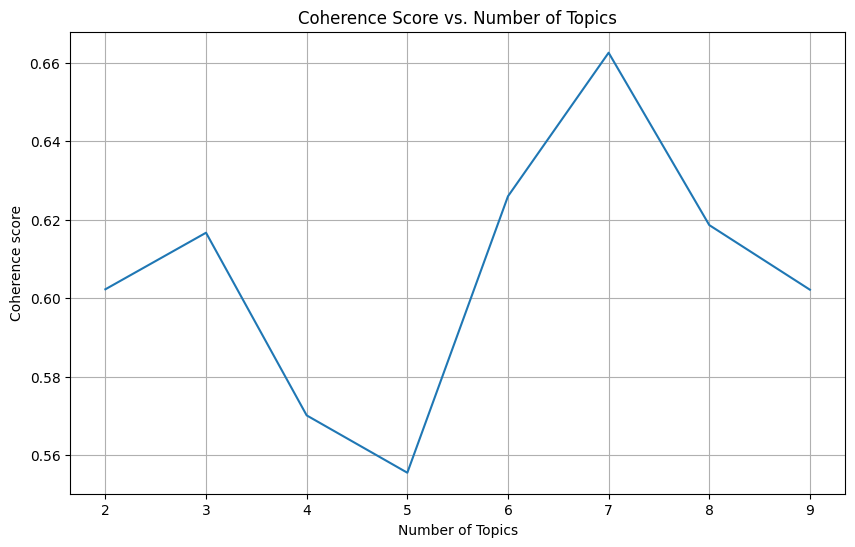

In [45]:
# Plot coherence values
plt.figure(figsize=(10, 6))
# Use the same start, limit, and step as used for computing coherence_values
start_plot, limit_plot, step_plot = 2, 10, 1 # Explicitly use the values from cell YOEYi23ttaP0
x = range(start_plot, limit_plot, step_plot)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.title("Coherence Score vs. Number of Topics")
# Ensure ticks match the evaluated topic numbers
plt.xticks(np.arange(start_plot, limit_plot, step_plot))
plt.grid(True)
plt.savefig('coherence_score_vs_topics.png')  # This line saves the graph to a file
plt.show() # This line displays the plot

In [40]:
plt.savefig('coherence_score_vs_topics.png')

<Figure size 640x480 with 0 Axes>

In [41]:
plt.show()

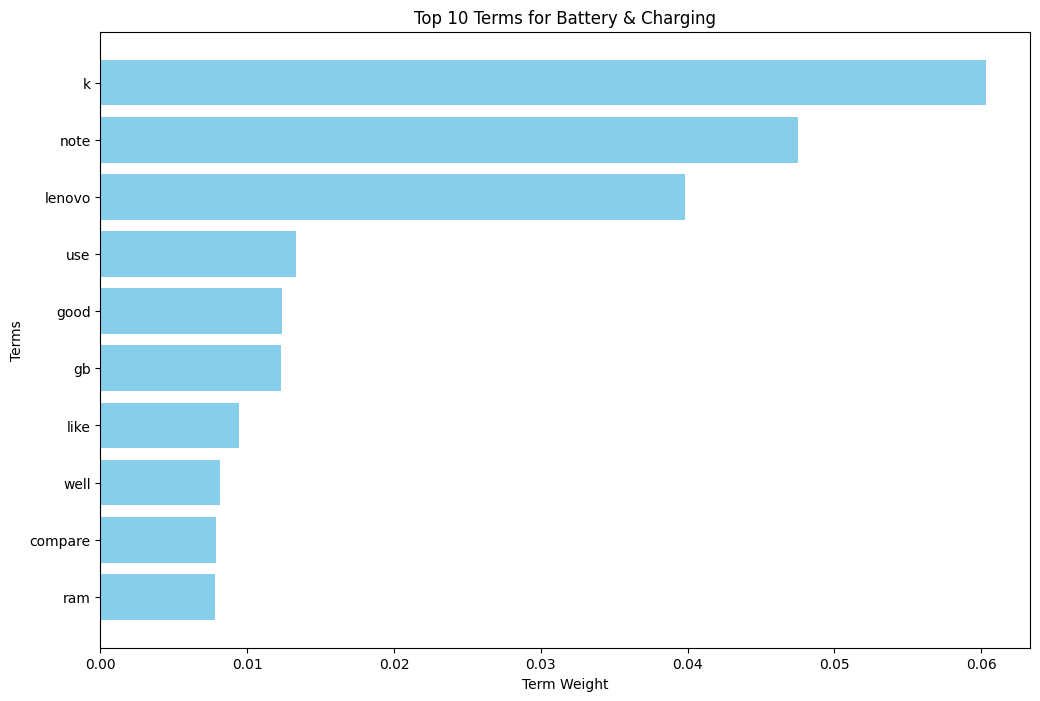

In [47]:
import matplotlib.pyplot as plt

# Assuming lda_model_optimal and topic_names are already defined from previous steps

# Choose a specific topic to visualize (e.g., Topic 1)
topic_to_visualize = 0  # Python is 0-indexed, so 0 corresponds to Topic 1

# Get the top terms and their weights for the selected topic
topic_terms = lda_model_optimal.get_topic_terms(topic_to_visualize, topn=10)
term_ids = [term[0] for term in topic_terms]
term_weights = [term[1] for term in topic_terms]
terms = [dictionary[id] for id in term_ids]

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.barh(terms, term_weights, color='skyblue')
plt.xlabel('Term Weight')
plt.ylabel('Terms')
plt.title(f'Top 10 Terms for {topic_names[f"Topic {topic_to_visualize + 1}"]}')
plt.gca().invert_yaxis()
plt.show()